In [1]:
from math import log
import random
import numpy as np
import cvxpy as cp
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams.update({'mathtext.default': 'regular' })

In [3]:
def create_sparse_vector(n, s):
    x = np.zeros(n)  # Initialize zero vector
    indices = np.random.permutation(n)[:s]  # Randomly select s indices
    x[indices] = np.random.randn(s)  # Assign random values at selected indices

    return x

## Question 2.

$A \in \mathbb{R}^{m \times n}$ and $x_s \in \mathbb{R}^n$ with $s$ number of nonzero elements. Let $m \gtrapprox 2s \log (n) \ll n$

In [4]:
def sgn(x):
    return np.where(x < 0, -1, 1)

In [5]:
def lasso_grad(A, x, b, lambd):
    return A.T @ (A @ x - b) + lambd * sgn(x)

def h(x):
    return np.linalg.norm(x, 1)

def projected_subgrad_descent(A, x, b, h_opt, c):

    n = len(x)
    k = 0

    A_pinv = np.linalg.pinv(A)
    A_pinv_A = A_pinv @ A
    A_pinv_b = A_pinv @ b

    x = x - A_pinv_A @ x + A_pinv_b
    h_val = h(x)
    
    differences = []
    
    while h_val >= c * h_opt:

        u = x - (1 / sqrt(n*(k+1))) * sgn(x)
        x = u - A_pinv_A @ u + A_pinv_b
            
        k += 1
        
        h_val = np.linalg.norm(x, 1)
        
        differences.append(h_val - h_opt)
                 
    return x, differences

In [6]:
np.random.seed(44)
random.seed(44)

h_opt: 4.4114264971427675, h: 4.4532224171920305


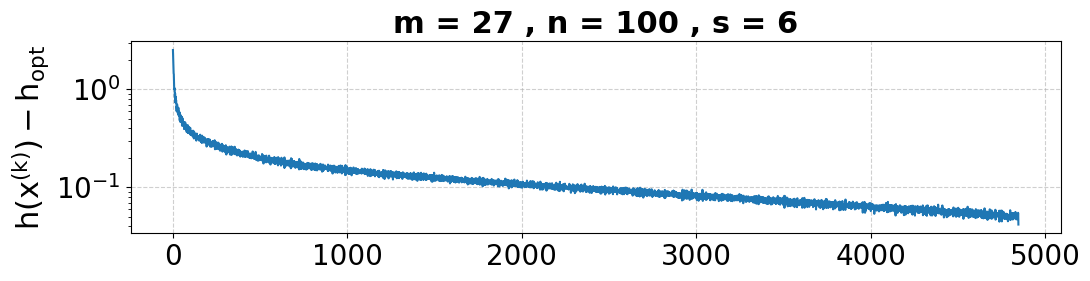

h_opt: 31.428684396601543, h: 31.739954756995132


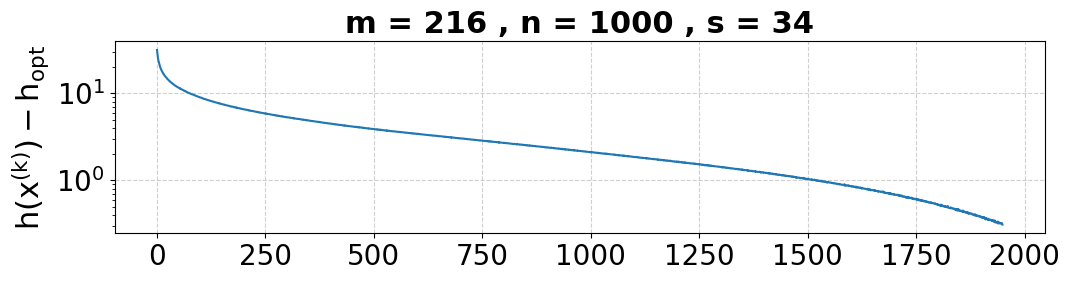

In [7]:
for m, n, s in [(27, 100, 6), (216, 1000, 34)]: # (216, 1000, 34)

    # Create Problem
    A = np.random.randn(m, n)
    x_s = create_sparse_vector(n, s)
    b = A @ x_s
    
    x = cp.Variable(n)
    
    prob = cp.Problem(
        cp.Minimize(cp.norm1(x)),
        [(A @ x == b)]
    )
    
    prob.solve()

    np.zeros(n)
    
    h_opt = h(x.value)
    x_subgrad, differences = projected_subgrad_descent(A, np.zeros(n), b, h_opt, 1.01)
    
    print(f'h_opt: {h_opt}, h: {h(x_subgrad)}')


    
    pdf = PdfPages(f'plots/2.3_proj_subgrad_{m}_{n}.pdf')
    plt.figure(figsize=(12, 3))
    
    k = [i for i in range(len(differences))]
    
    plt.plot(k, differences)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Label the axes
    #plt.xlabel('$k$')
    plt.ylabel('$h(x^{(k)}) - h_{opt}$')
    
    #plt.xscale('log')
    plt.yscale('log')
    
    plt.subplots_adjust(bottom=0.24)
    
    plt.title(f"m = {m} , n = {n} , s = {s}")
    
    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()

    
    

In [15]:
4.411 - 4.453 

-0.0420000000000007

## Question 3.

In [8]:
def T(x, tau):
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0.0)

In [9]:
def s_fista(A, x, b, h_opt, epsilon):
    
    n = len(x)

    m = epsilon / n
    
    t = 1
    k = 0

    A_pinv = np.linalg.pinv(A)
    A_pinv_A = A_pinv @ A
    A_pinv_b = A_pinv @ b

    x = x - A_pinv_A @ x + A_pinv_b
    y = x
    h_val = h(x)
    
    differences = []
    
    while h_val - h_opt >= epsilon:


        u = T(y, m)

        old_x = x
        x = u - A_pinv_A @ u + A_pinv_b

        old_t = t
        t = (1 + sqrt(1 + 4 * t**2)) / 2
        
        y = x + ((old_t - 1) / t ) * (x - old_x)
            
        k += 1
        
        h_val = h(x)
        
        differences.append(h_val - h_opt)
                 
    return x, differences

In [16]:
np.random.seed(44)
random.seed(44)

h_opt: 4.4114264971427675, h: 4.45303845092073


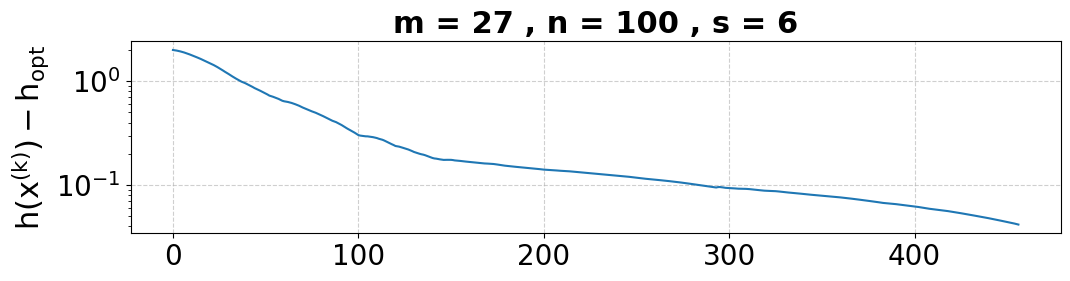

h_opt: 31.428684396601543, h: 31.73269843407163


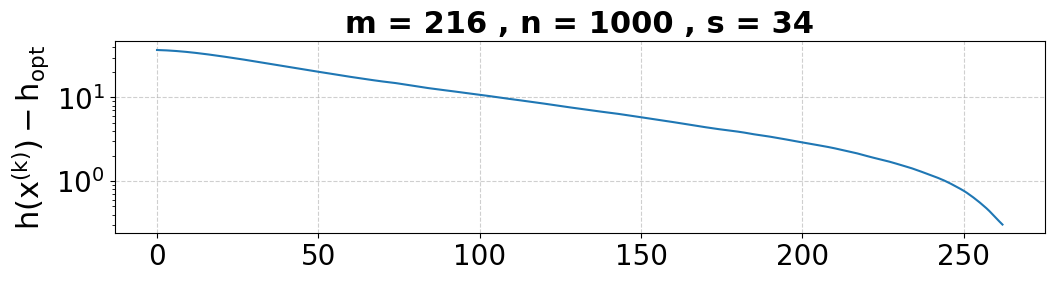

In [17]:
for m, n, s, epsilon in [(27, 100, 6, 0.042), (216, 1000, 34, 0.31)]: # (216, 1000, 34)

    # Create Problem
    A = np.random.randn(m, n)
    x_s = create_sparse_vector(n, s)
    b = A @ x_s
    
    x = cp.Variable(n)
    
    prob = cp.Problem(
        cp.Minimize(cp.norm1(x)),
        [(A @ x == b)]
    )
    
    prob.solve()

    np.zeros(n)
    
    h_opt = h(x.value)
    x_fista, differences_fista = s_fista(A, np.zeros(n), b, h_opt, epsilon)
    
    print(f'h_opt: {h_opt}, h: {h(x_fista)}')


    
    pdf = PdfPages(f'plots/2.3_fista_{m}_{n}.pdf')
    plt.figure(figsize=(12, 3))
    
    k_fista = [i for i in range(len(differences_fista))]
    
    plt.plot(k_fista, differences_fista)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Label the axes
    #plt.xlabel('$k$')
    plt.ylabel('$h(x^{(k)}) - h_{opt}$')
    
    #plt.xscale('log')
    plt.yscale('log')
    
    plt.subplots_adjust(bottom=0.24)
    
    plt.title(f"m = {m} , n = {n} , s = {s}")
    
    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()

## Question 4.

0.041795920049263025


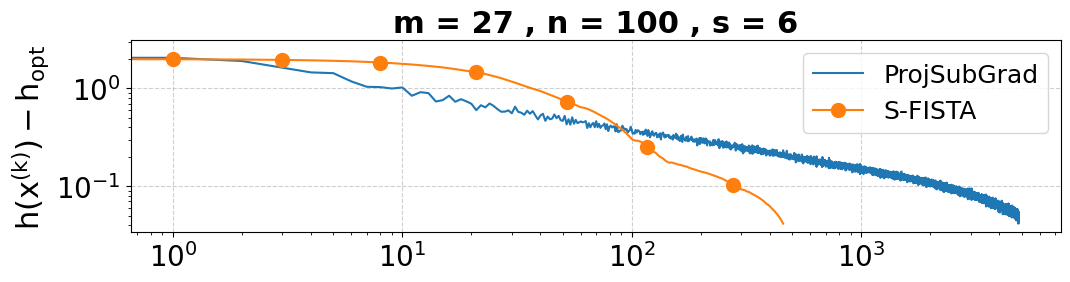

0.31127036039358913


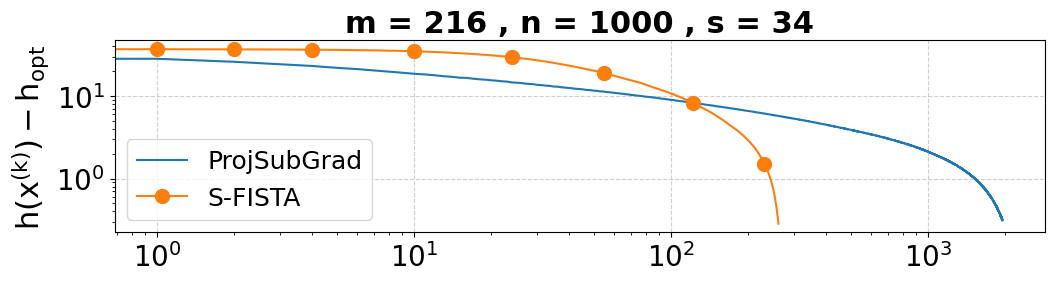

In [12]:
np.random.seed(44)
random.seed(44)

for m, n, s in [(27, 100, 6), (216, 1000, 34)]:

    # Create Problem
    A = np.random.randn(m, n)
    x_s = create_sparse_vector(n, s)
    b = A @ x_s
    
    x = cp.Variable(n)
    
    prob = cp.Problem(
        cp.Minimize(cp.norm1(x)),
        [(A @ x == b)]
    )
    
    prob.solve()

    np.zeros(n)
    
    h_opt = h(x.value)
    x_subgrad, differences_subgrad = projected_subgrad_descent(A, np.zeros(n), b, h_opt, 1.01)

    epsilon = h(x_subgrad) - h_opt
    print(epsilon)

    x_fista, differences_fista = s_fista(A, np.zeros(n), b, h_opt, epsilon)    
    
    pdf = PdfPages(f'plots/2.3_sfista_vs_proj_{m}_{n}.pdf')
    plt.figure(figsize=(12, 3))
    
    k_subgrad = [i for i in range(len(differences_subgrad))]
    k_fista = [i for i in range(len(differences_fista))]
    
    plt.plot(k_subgrad, differences_subgrad, label="ProjSubGrad")
    plt.plot(k_fista, differences_fista, label="S-FISTA", marker="o", markevery=0.1, ms=10)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Label the axes
    #plt.xlabel('$k$')
    plt.ylabel('$h(x^{(k)}) - h_{opt}$')
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.subplots_adjust(bottom=0.24)
    
    plt.title(f"m = {m} , n = {n} , s = {s}")

    plt.legend()
    
    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()
